In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from scipy import spatial
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import copy

In [9]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [10]:
dataset_mnist_train = torchvision.datasets.MNIST(
    root='',
    transform=torchvision.transforms.ToTensor(),
    train=True,
    download=True
)
dataset_mnist_test = torchvision.datasets.MNIST(
    root='',
    transform=torchvision.transforms.ToTensor(),
    train=False,
    download=True
)

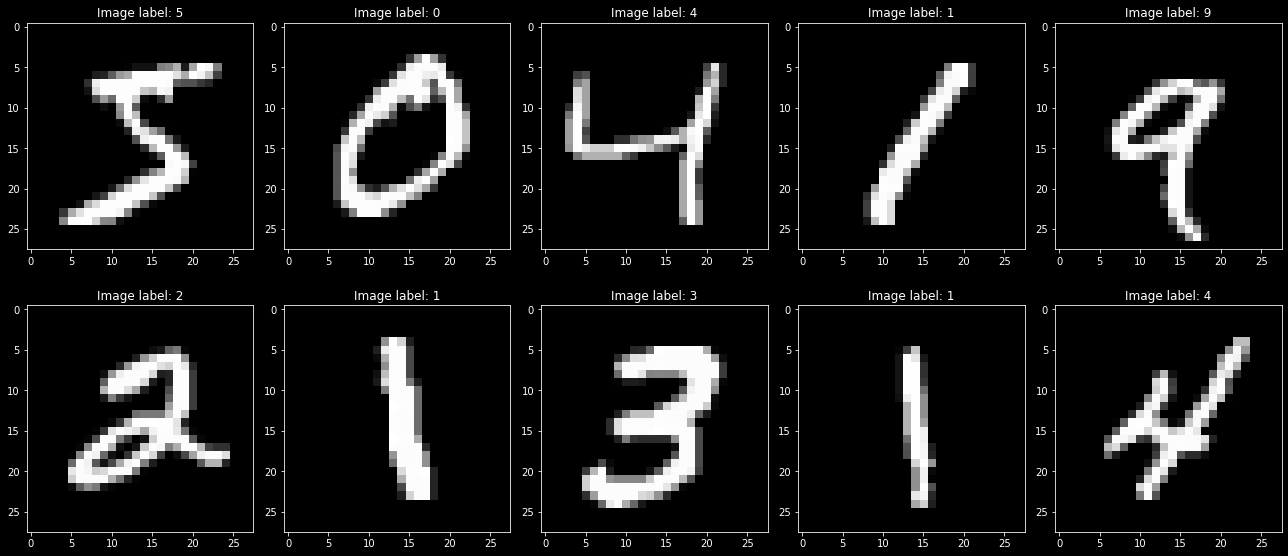

In [11]:
rows = 2
cols = 5
axes = []
fig = plt.figure()
fig.set_size_inches(18,8)

for i in range(rows * cols):
    tensor, label = dataset_mnist_train[i]
    arr = tensor.numpy()

    axes.append(fig.add_subplot(rows, cols, i+1))
    axes[-1].set_title(f'Image label: {label}')
    plt.imshow(arr[0], cmap='gray')
fig.tight_layout()
plt.show()

$$
\text{Originally:} 
\\
\\
x_i \in \mathbb{R^{28^{28}}}
\\
\\
\text{but}
\\
\\
\mathbb{R^{28^{28}}} \iff \mathbb{R^{28 \cdot 28}} \iff \mathbb{R^{784}} 
\\
\\
\text{thus}
\\
\\
\begin{bmatrix}0&\cdots&1\\\vdots&\cdots&\vdots \\0&\cdots&1\end{bmatrix}\mapsto(0,0, \cdots, 1)
$$

In [250]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [251]:
network = MLP()
optimizer = optim.Adam(network.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss()

In [252]:
device = torch.device('cpu')
network = network.to(device)

In [253]:
BATCH_SIZE = 600
NUM_WORKERS = 2

train_loader = DataLoader(
    dataset = dataset_mnist_train,
    batch_size=BATCH_SIZE
)

test_loader = DataLoader(
    dataset=dataset_mnist_test,
    batch_size=len(dataset_mnist_test)
)

In [254]:
model_counter = 0
counter = 0
for epoch in range(10):
    losses = []
    pbar = tqdm(train_loader, total=len(dataset_mnist_train)//BATCH_SIZE)
    for images, labels in pbar:
        optimizer.zero_grad()
        images = images.squeeze(1).flatten(start_dim=1)
        images = images.to(device)
        labels = labels.to(device)

        output = network(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        pbar.set_description(f'Loss: {round(loss.item(),3)}')

        if counter % 10 == 0:
            torch.save(network.state_dict(), f'./model_3/epoch_{model_counter}.pth')
            model_counter += 1
        counter += 1

Loss: 0.272: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


## Evaluate accuracy along each models training trajectory (independently):

In [255]:
def load_model(model_path):
    model = MLP()
    model.load_state_dict(torch.load(model_path))
    return model

In [256]:
model_1_names = sorted(os.listdir('model_1'), key=lambda x: int(x.split('_')[1].split('.')[0]))
model_2_names = sorted(os.listdir('model_2'), key=lambda x: int(x.split('_')[1].split('.')[0]))
model_3_names = sorted(os.listdir('model_3'), key=lambda x: int(x.split('_')[1].split('.')[0]))

model_1_paths = [os.path.join('./model_1', x) for x in model_1_names]
model_2_paths = [os.path.join('./model_2', x) for x in model_2_names]
model_3_paths = [os.path.join('./model_3', x) for x in model_3_names]

models_1 = [load_model(path) for path in model_1_paths]
models_2 = [load_model(path) for path in model_2_paths]
models_3 = [load_model(path) for path in model_3_paths]

In [257]:
def get_model_predictions(model):
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.squeeze(1).flatten(start_dim=1)
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = F.softmax(model(images), dim=1)
            preds = torch.argmax(outputs, dim=1)
            preds = preds.numpy()
    return preds

In [49]:
model_1_predictions = [get_model_predictions(model) for model in tqdm(models_1)]
model_2_predictions = [get_model_predictions(model) for model in tqdm(models_2)]
model_3_predictions = [get_model_predictions(model) for model in tqdm(models_3)]

100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


In [50]:
def get_acc(preds, labels):
    return (preds == labels).mean()

In [51]:
def get_labels():
    for _, labels in test_loader:
        return labels.detach().numpy()

In [52]:
labels = get_labels()

model_1_accs = [get_acc(preds, labels) for preds in model_1_predictions]
model_2_accs = [get_acc(preds, labels) for preds in model_2_predictions]
model_3_accs = [get_acc(preds, labels) for preds in model_3_predictions]

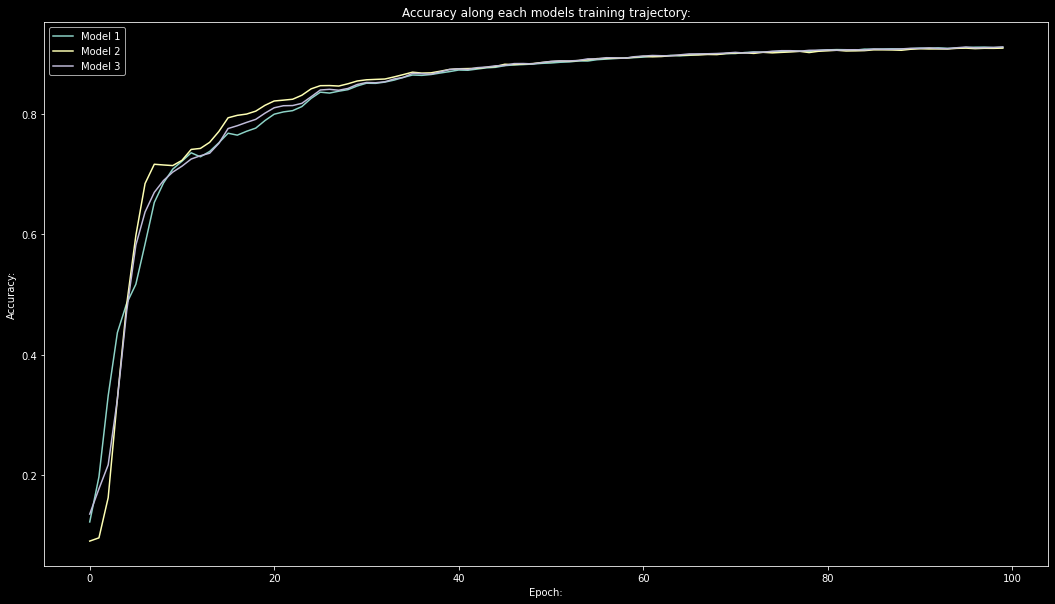

In [53]:
plt.gcf().set_size_inches(18, 10)
plt.plot(range(len(model_1_accs)), model_1_accs, label='Model 1')
plt.plot(range(len(model_2_accs)), model_2_accs, label='Model 2')
plt.plot(range(len(model_3_accs)), model_3_accs, label='Model 3')
plt.title('Accuracy along each models training trajectory:')
plt.xlabel('Epoch:')
plt.ylabel('Accuracy:')
plt.legend()
plt.show()

## Evaluate cosine similarity between successive training epochs:
* Calculate how similar model parameters are between successive epochs.

$$
\text{similarity} = cos(\theta) = \frac{x_1 \cdot x_2}{\lVert x_1 \rVert \lVert x_2 \lVert} \in [0, 1]
$$

In [54]:
def get_weight_vector(model):
    weight_tensors = [i for i in list(model.parameters())]
    weights = [i.detach().numpy() for i in weight_tensors]
    flattened_weights = [i.flatten() for i in weights]
    weight_vector = np.concatenate(flattened_weights)
    return weight_vector

In [55]:
weight_vectors_1 = [get_weight_vector(model) for model in models_1]
weight_vectors_2 = [get_weight_vector(model) for model in models_2]
weight_vectors_3 = [get_weight_vector(model) for model in models_3]

In [56]:
similarities_1 = []
similarities_2 = []
similarities_3 = []

for i in range(len(weight_vectors_1)-1):
    similarity_1  = 1 - spatial.distance.cosine(weight_vectors_1[i], weight_vectors_1[i+1])
    similarity_2  = 1 - spatial.distance.cosine(weight_vectors_2[i], weight_vectors_2[i+1])
    similarity_3  = 1 - spatial.distance.cosine(weight_vectors_3[i], weight_vectors_3[i+1])
    similarities_1.append(similarity_1)
    similarities_2.append(similarity_2)
    similarities_3.append(similarity_3)
similarities_1 = np.array(similarities_1)
similarities_2 = np.array(similarities_2)
similarities_3 = np.array(similarities_3)

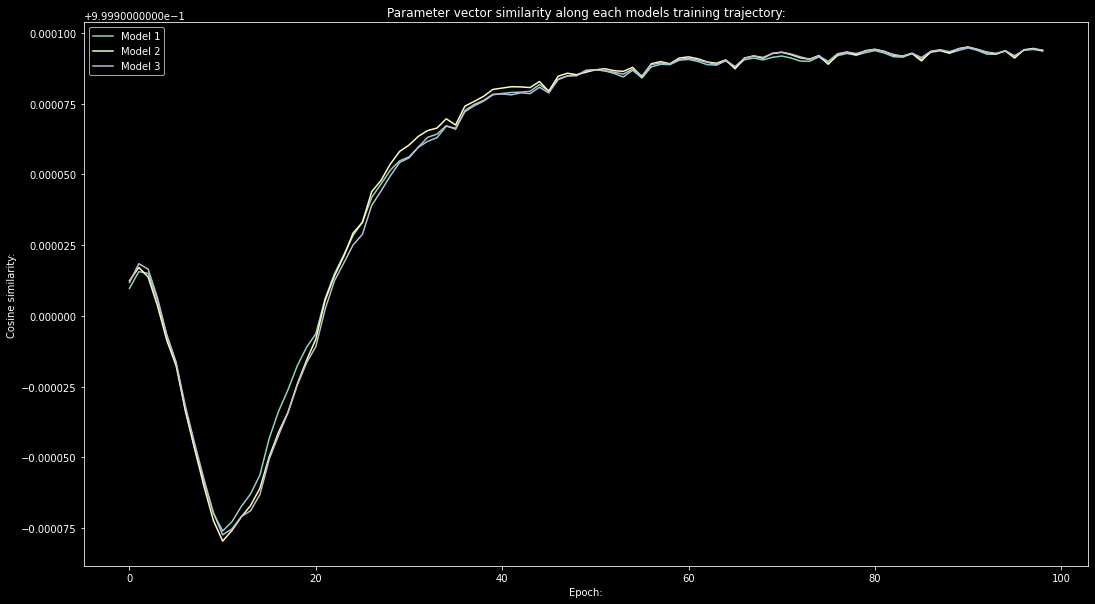

In [57]:
plt.gcf().set_size_inches(18, 10)
plt.plot(range(len(similarities_1)), similarities_1, label='Model 1')
plt.plot(range(len(similarities_2)), similarities_2, label='Model 2')
plt.plot(range(len(similarities_3)), similarities_3, label='Model 3')
plt.xlabel('Epoch:')
plt.ylabel('Cosine similarity:')
plt.title('Parameter vector similarity along each models training trajectory:')
plt.legend()
plt.show()

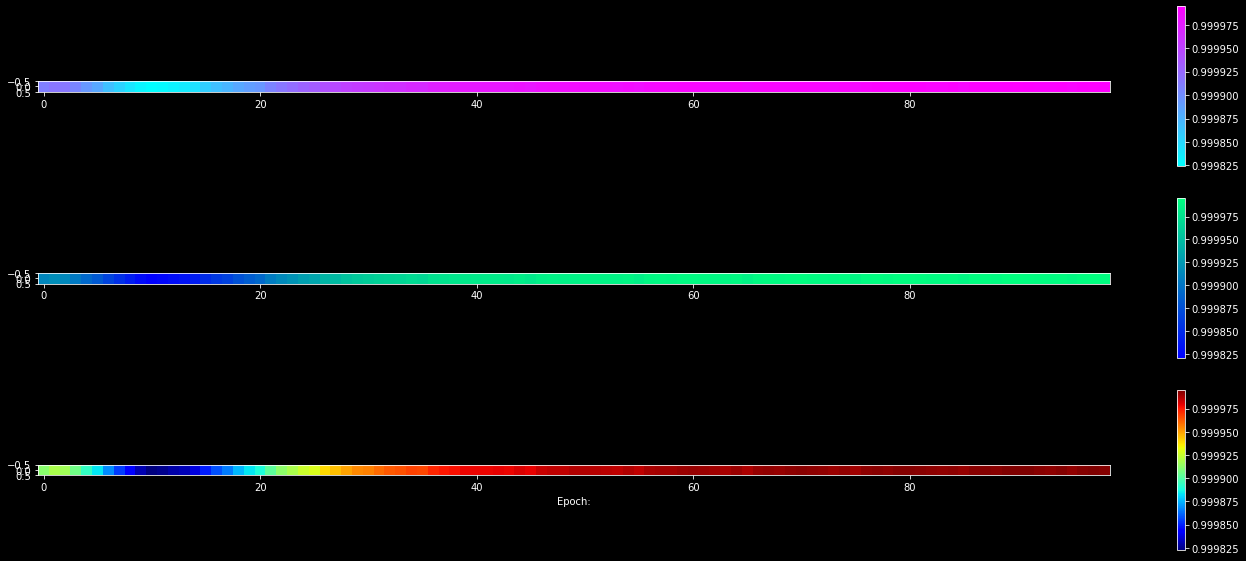

In [59]:
fig, ax = plt.subplots(3)
fig.set_size_inches(24, 10)

im1 = ax[0].imshow(similarities_1.reshape(1,-1), cmap='cool')
im2 = ax[1].imshow(similarities_2.reshape(1,-1), cmap='winter')
im3 = ax[2].imshow(similarities_3.reshape(1,-1), cmap='jet')

plt.colorbar(im1, ax=ax[0])
plt.colorbar(im2, ax=ax[1])
plt.colorbar(im3, ax=ax[2])
plt.xlabel('Epoch:')
plt.show()

## Evaluate the proportion of samples on which successive epochs agree:
* Calculate the proportion of predictions that remain constant between epochs. 

In [60]:
agreement_proportions_1 = []
agreement_proportions_2 = []
agreement_proportions_3 = []

for i in range(len(model_1_predictions)-1):
    preds_1_1, preds_2_1 = model_1_predictions[i], model_1_predictions[i+1]
    preds_1_2, preds_2_2 = model_2_predictions[i], model_2_predictions[i+1]
    preds_1_3, preds_2_3 = model_3_predictions[i], model_3_predictions[i+1]

    agreement_proportion_1 = (preds_1_1 == preds_2_1).mean()
    agreement_proportion_2 = (preds_1_2 == preds_2_2).mean()
    agreement_proportion_3 = (preds_1_3 == preds_2_3).mean()

    agreement_proportions_1.append(agreement_proportion_1)
    agreement_proportions_2.append(agreement_proportion_2)
    agreement_proportions_3.append(agreement_proportion_3)
agreement_proportions_1 = np.array(agreement_proportions_1)
agreement_proportions_2 = np.array(agreement_proportions_2)
agreement_proportions_3 = np.array(agreement_proportions_3)

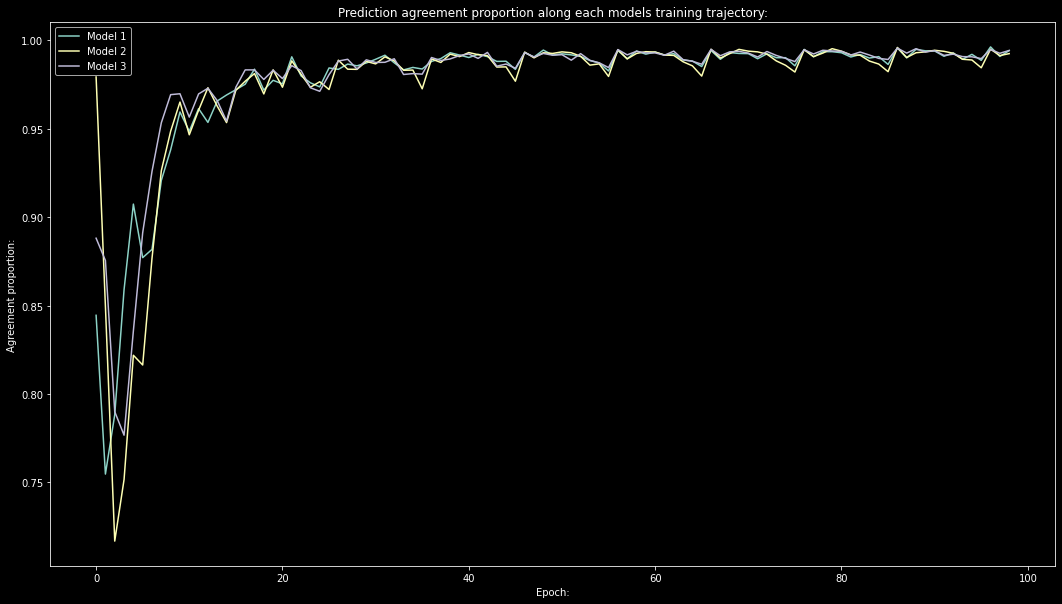

In [61]:
plt.gcf().set_size_inches(18, 10)
plt.plot(range(len(agreement_proportions_1)), agreement_proportions_1, label='Model 1')
plt.plot(range(len(agreement_proportions_2)), agreement_proportions_2, label='Model 2')
plt.plot(range(len(agreement_proportions_3)), agreement_proportions_3, label='Model 3')
plt.xlabel('Epoch:')
plt.ylabel('Agreement proportion:')
plt.title('Prediction agreement proportion along each models training trajectory:')
plt.legend()
plt.show()

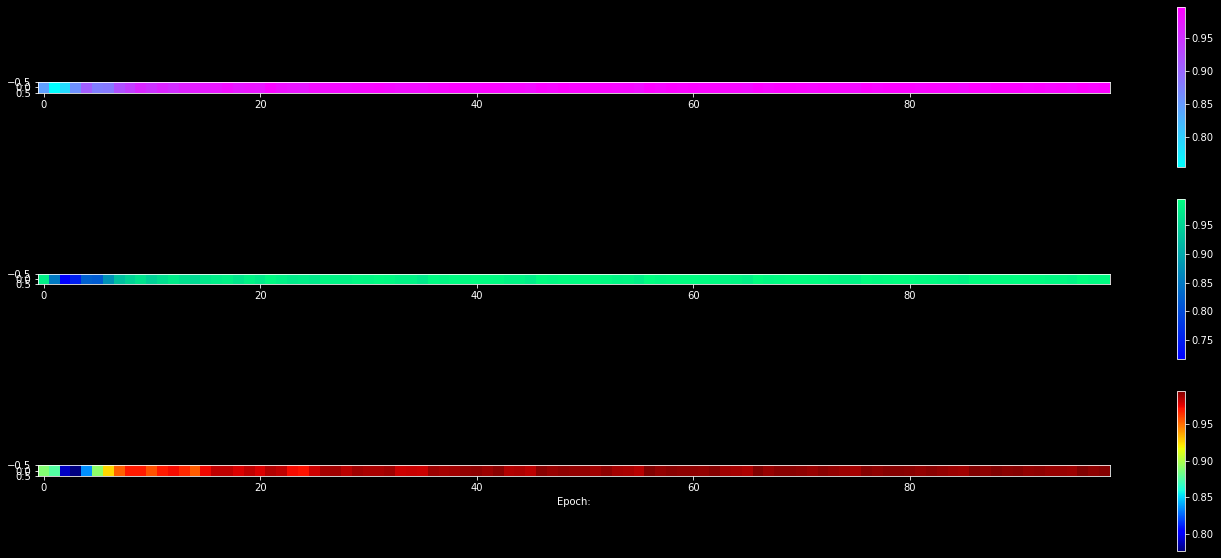

In [62]:
agreements = (agreement_proportions_1, agreement_proportions_2, agreement_proportions_3)
fig, ax = plt.subplots(3)
fig.set_size_inches(24, 10)

im1 = ax[0].imshow(agreements[0].reshape(1,-1), cmap='cool')
im2 = ax[1].imshow(agreements[1].reshape(1,-1), cmap='winter')
im3 = ax[2].imshow(agreements[2].reshape(1,-1), cmap='jet')

plt.colorbar(im1, ax=ax[0])
plt.colorbar(im2, ax=ax[1])
plt.colorbar(im3, ax=ax[2])
plt.xlabel('Epoch:')
plt.show()

## Analyse each models training trajectory in weight space:

In [63]:
tsne = TSNE(n_components=2)
pca = PCA(n_components=2)

embedded_vectors_1_tsne = tsne.fit_transform(weight_vectors_1)
embedded_vectors_2_tsne = tsne.fit_transform(weight_vectors_2)
embedded_vectors_3_tsne = tsne.fit_transform(weight_vectors_3)

embedded_vectors_1_pca = pca.fit_transform(weight_vectors_1)
embedded_vectors_2_pca = pca.fit_transform(weight_vectors_2)
embedded_vectors_3_pca = pca.fit_transform(weight_vectors_3)

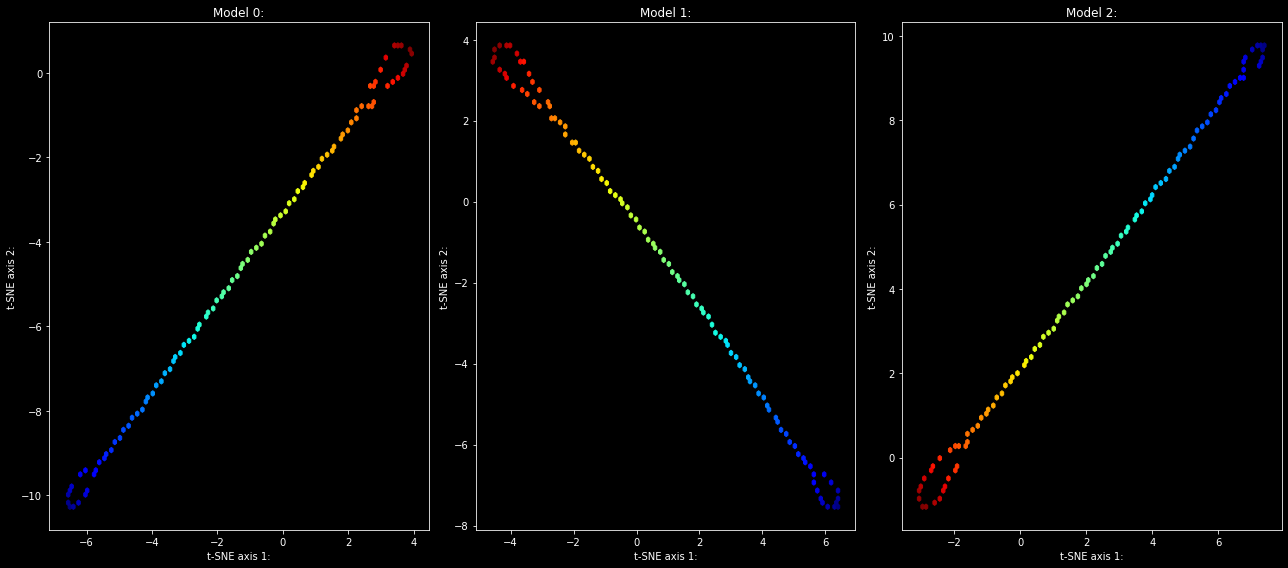

In [64]:
rows = 1
cols = 3
axes = []
fig = plt.figure()
fig.set_size_inches(18,8)
embeddings = (embedded_vectors_1_tsne, embedded_vectors_2_tsne, embedded_vectors_3_tsne)

for i in range(rows * cols):
    axes.append(fig.add_subplot(rows, cols, i+1))
    axes[-1].set_title(f'Model {i}:')
    plt.hexbin(embeddings[i][:, 0], embeddings[i][:, 1], C=range(len(embeddings[i])), cmap='jet')
    plt.xlabel('t-SNE axis 1:')
    plt.ylabel('t-SNE axis 2:')
fig.tight_layout()
plt.show()

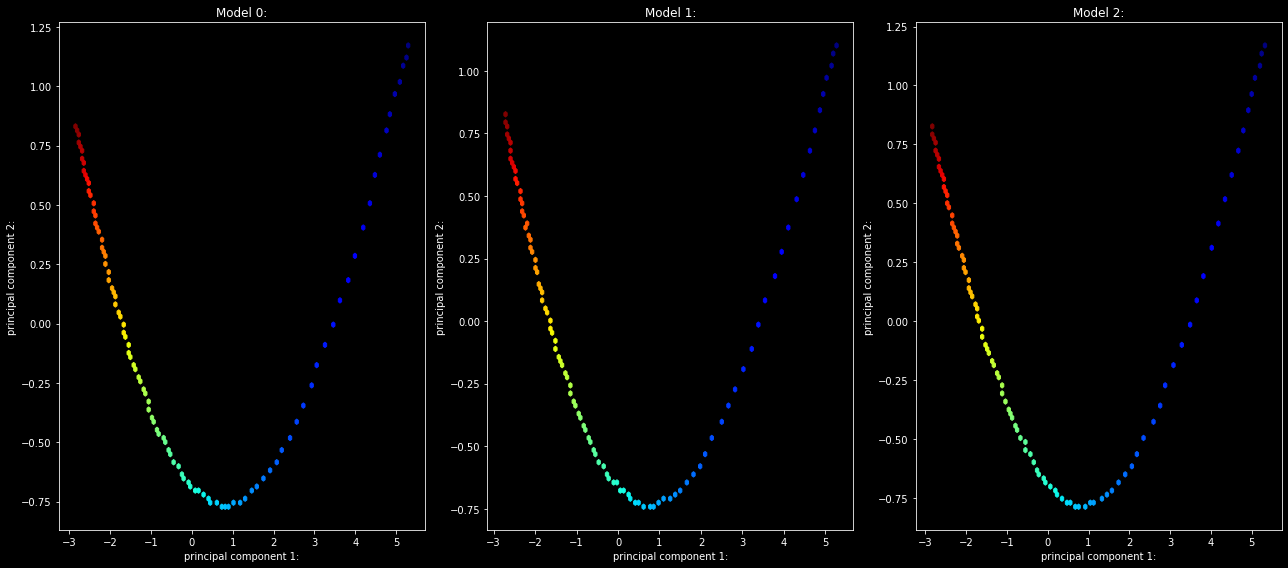

In [65]:
rows = 1
cols = 3
axes = []
fig = plt.figure()
fig.set_size_inches(18,8)
embeddings = (embedded_vectors_1_pca, embedded_vectors_2_pca, embedded_vectors_3_pca)

for i in range(rows * cols):
    axes.append(fig.add_subplot(rows, cols, i+1))
    axes[-1].set_title(f'Model {i}:')
    plt.hexbin(embeddings[i][:, 0], embeddings[i][:, 1], C=range(len(embeddings[i])), cmap='jet')
    plt.xlabel('principal component 1:')
    plt.ylabel('principal component 2:')
fig.tight_layout()
plt.show()

## Compare the training trajectories of all of the models in weight space:

In [66]:
all_weights = np.concatenate([weight_vectors_1, weight_vectors_2, weight_vectors_3])
all_embeddings_tsne = tsne.fit_transform(all_weights)
all_embeddings_pca = pca.fit_transform(all_weights)
all_accs = np.concatenate((model_1_accs, model_2_accs, model_3_accs))

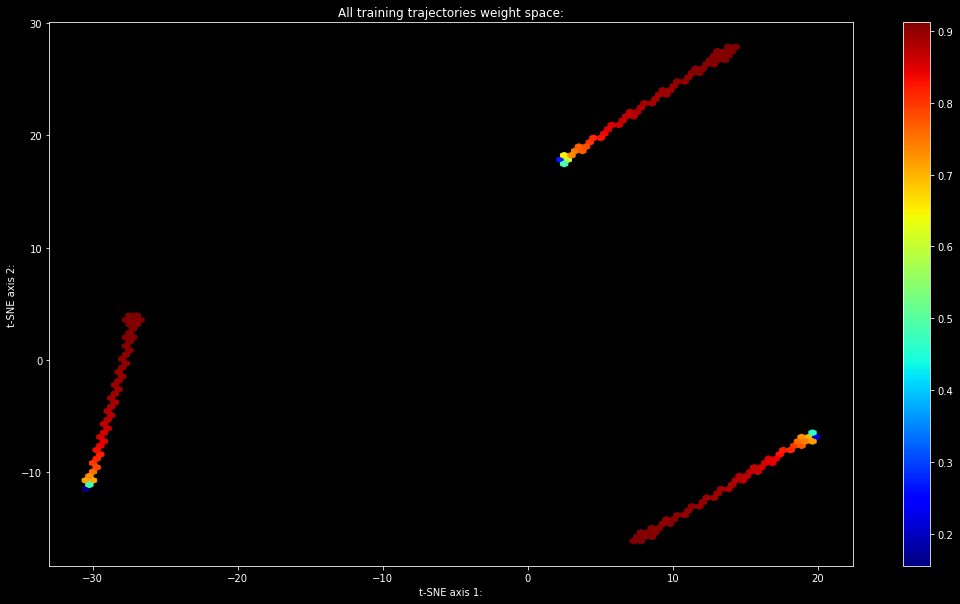

In [67]:
plt.gcf().set_size_inches(18,10)
plt.hexbin(all_embeddings_tsne[:, 0], all_embeddings_tsne[:, 1], C=all_accs, cmap='jet')
plt.xlabel('t-SNE axis 1:')
plt.ylabel('t-SNE axis 2:')
plt.title('All training trajectories weight space:')
plt.colorbar()
plt.show()

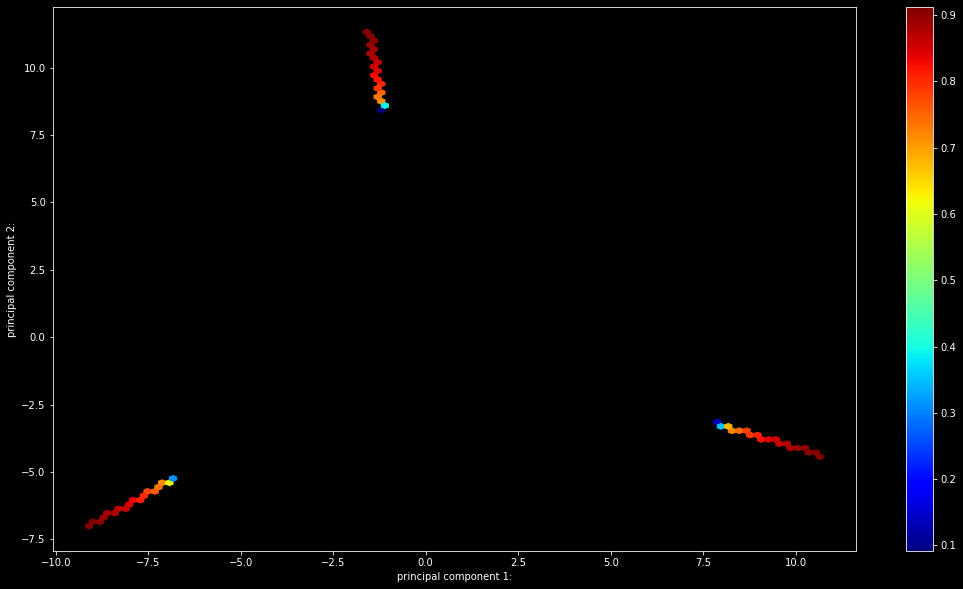

In [68]:
plt.gcf().set_size_inches(18,10)
plt.hexbin(all_embeddings_pca[:, 0], all_embeddings_pca[:, 1], C=all_accs, cmap='jet')
plt.xlabel('principal component 1:')
plt.ylabel('principal component 2:')
plt.colorbar()
plt.show()

## Compare similarity between model parameters accross all epochs:
* Calculate cosine similarity between model parameters for a given epoch and all other epochs.

In [69]:
similarities = np.zeros(shape=(100,100))

In [70]:
for i in range(100):
    vec_one = weight_vectors_1[i]
    for x in range(100):
        vec_two = weight_vectors_1[x]
        similarity = 1 - spatial.distance.cosine(vec_one, vec_two)
        similarities[i][x] = similarity

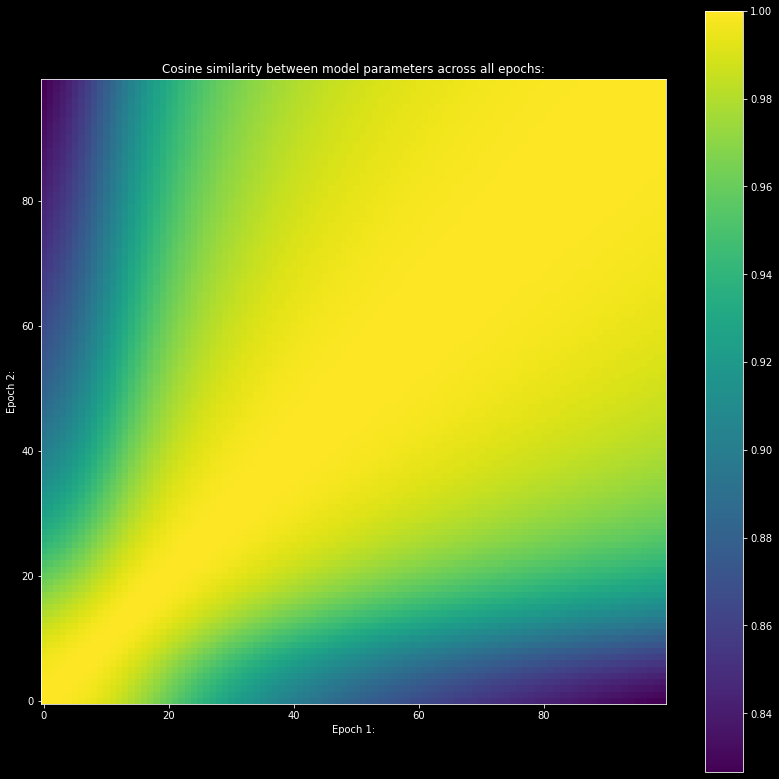

In [71]:
plt.gcf().set_size_inches(14,14)
plt.title('Cosine similarity between model parameters across all epochs:')
plt.imshow(similarities, origin='lower')
plt.xlabel('Epoch 1:')
plt.ylabel('Epoch 2:')
plt.colorbar()

## Compare the proportion of samples a models agree on accross all epochs:
* Calculate the proportion of samples a model at a given epoch is in agreement with each model at all other epochs.

In [72]:
agreements = np.zeros(shape=(100,100))
for i in range(100):
    preds_one = model_1_predictions[i]
    for x in range(100):
        preds_two = model_1_predictions[x]
        agreement = (preds_one ==  preds_two).mean()
        agreements[i][x] = agreement

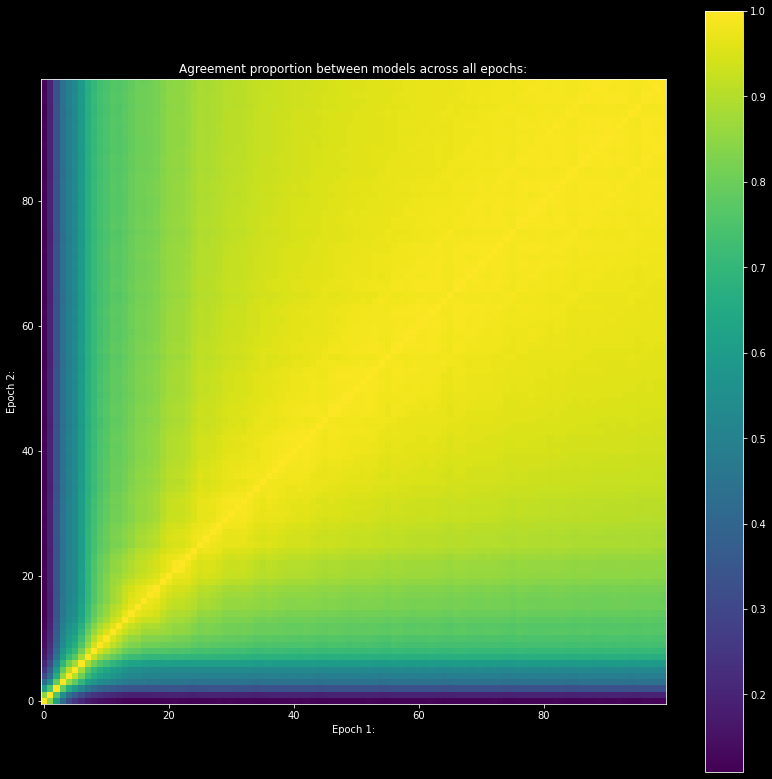

In [73]:
plt.gcf().set_size_inches(14,14)
plt.title('Agreement proportion between models across all epochs:')
plt.imshow(agreements, origin='lower')
plt.xlabel('Epoch 1:')
plt.ylabel('Epoch 2:')
plt.colorbar()
plt.show()

## Analysing similarity of functions within a subspace from each trajectory and accross trajectories:

### Random subspace method:

$$
\text{Original network paramaters: } \Theta
\\
\text{Optimised network paramaters: } \Theta^*
\\
\text{To create a new network:}
\\
\text{Let new network's parameters be denoted by: } \Theta'
\\
\Theta' = \Theta + \alpha v
\\
\text{where} 
\\
v \in \mathbb{R^{n}}, n = dim \Theta, v \sim U(0, 1)
\\
\alpha \in \mathbb{R} 
$$

In [74]:
model_one = copy.deepcopy(models_1[-1])
model_two = copy.deepcopy(models_2[-1])
model_three = copy.deepcopy(models_3[-3])

In [75]:
def generate_random_subspace_ensemble(model):
    ensemble = []
   
    for i in range(50):
        model_prime = copy.deepcopy(model)

        for name, params in model_prime.named_parameters():
            params_prime = params + 0.1 * torch.rand(params.shape)
            params.data.copy_(params_prime)
        ensemble.append(model_prime)
    return ensemble

In [76]:
ensemble_one = generate_random_subspace_ensemble(model_one)
ensemble_two = generate_random_subspace_ensemble(model_two)
ensemble_three = generate_random_subspace_ensemble(model_three)

In [77]:
weight_vector_arrray_one = [get_weight_vector(model) for model in ensemble_one]
weight_vector_arrray_two = [get_weight_vector(model) for model in ensemble_two]
weight_vector_arrray_three = [get_weight_vector(model) for model in ensemble_three]

In [78]:
all_weight_vectors = np.concatenate((weight_vector_arrray_one, weight_vector_arrray_two, weight_vector_arrray_three))

In [79]:
tsne = TSNE(n_components=2)
all_embeddings = tsne.fit_transform(all_weight_vectors)

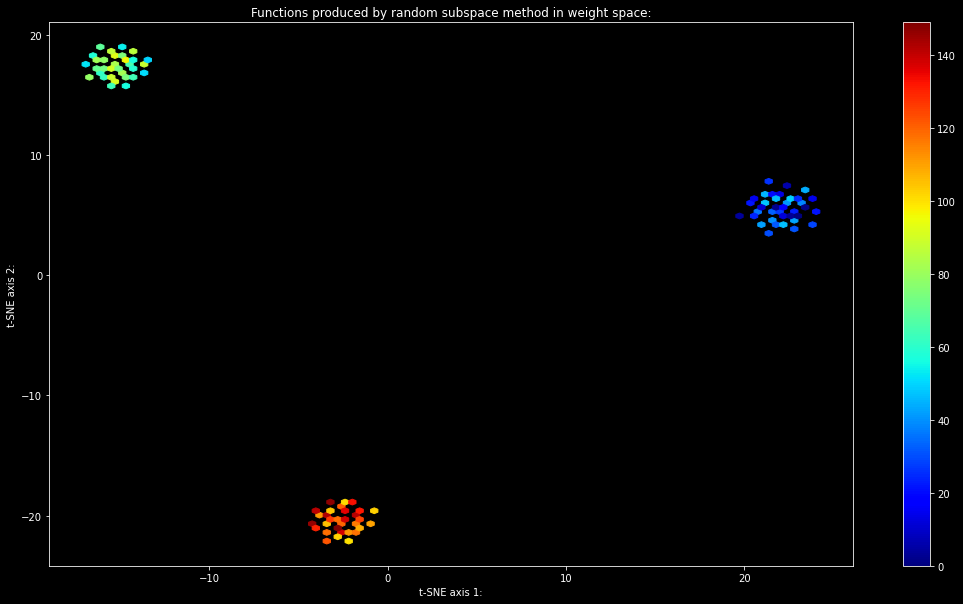

In [80]:
plt.gcf().set_size_inches(18,10)
plt.hexbin(all_embeddings[:, 0], all_embeddings[:, 1], C=range(len(all_embeddings)), cmap='jet')
plt.colorbar()
plt.xlabel('t-SNE axis 1:')
plt.ylabel('t-SNE axis 2:')
plt.title('Functions produced by random subspace method in weight space:')
plt.show()

### Diagonal Gaussian subspace:

$$
\text{Original network paramaters: } \Theta
\\
\text{Optimised network paramaters: } \Theta^*
\\
\text{Let } S \text{ be the set containing a given models parameters for the last } N \text{ epochs of training.}
\\
\text{That is } \Theta_i \in S \text{ is the models parameters after epoch } i \text{ of training.}
\\
\\
\text{Now for each } \theta_j \in \Theta \text{ calcuate the mean } \mu_j \text{ and the standard deviation } \sigma_j \text{ across the last } N \text{ epochs of training.}
\\
\text{To produce a new model a value for each } \theta_i \in \Theta \text{ must be created.}
\\
\text{Each new parameter value is created as follows:}
\\
\text{The mean } \mu_j \text{ and standard deviation } \sigma_j \text{ for parameter } \theta_j \text{ is used to create a normal distribution } \mathcal{N}(\mu_j, \sigma_j).
\\
\text{Then } \theta_j \sim \mathcal{N}(\mu_j, \sigma_j)
\\
$$

In [274]:
model_one_history = [copy.deepcopy(models_1[-i]) for i in range(20)]
model_two_history = [copy.deepcopy(models_2[-i]) for i in range(20)]
model_three_history = [copy.deepcopy(models_3[-i]) for i in range(20)]

In [275]:
def generate_diagonal_gaussian_subspace(model_history):
    all_params = []

    for model in model_history:
        model_params = {}
        for name, params in model.named_parameters():
            model_params[name] = params
        all_params.append(model_params)
    
    layer_names = list(all_params[0].keys())

    layer_means = {}
    layer_stds = {}

    for layer_name in layer_names:
        all_matrices = []
        for i in range(len(all_params)):
            all_matrices.append(all_params[i][layer_name].detach())
        all_matrices = torch.stack(all_matrices)

        layer_mean = all_matrices.mean(dim=0)
        layer_std = all_matrices.std(dim=0)
        layer_means[layer_name] = layer_mean
        layer_stds[layer_name] = layer_std
    
    for model in model_history:
        for layer_name, params in model.named_parameters():
            layer_mean = layer_means[layer_name]
            layer_std = layer_stds[layer_name]

            sampled_params = torch.randn(size=params.shape)
            sampled_params = sampled_params * layer_mean / (layer_std)
            sampled_params = torch.nan_to_num(sampled_params, nan=0, posinf=0, neginf=0)
            params.data.copy_(sampled_params)
    return model_history

In [302]:
ensemble_one = generate_diagonal_gaussian_subspace(model_one_history)
ensemble_two = generate_diagonal_gaussian_subspace(model_two_history)
ensemble_three = generate_diagonal_gaussian_subspace(model_three_history)

In [303]:
weight_vector_arrray_one = [get_weight_vector(model) for model in ensemble_one]
weight_vector_arrray_two = [get_weight_vector(model) for model in ensemble_two]
weight_vector_arrray_three = [get_weight_vector(model) for model in ensemble_three]

In [304]:
all_weight_vectors = np.concatenate((weight_vector_arrray_one, weight_vector_arrray_two, weight_vector_arrray_three))

In [279]:
tsne = TSNE(n_components=2)
pca = PCA(n_components=2)
all_embeddings_tsne = tsne.fit_transform(all_weight_vectors)
all_embeddings_pca = pca.fit_transform(all_weight_vectors) 

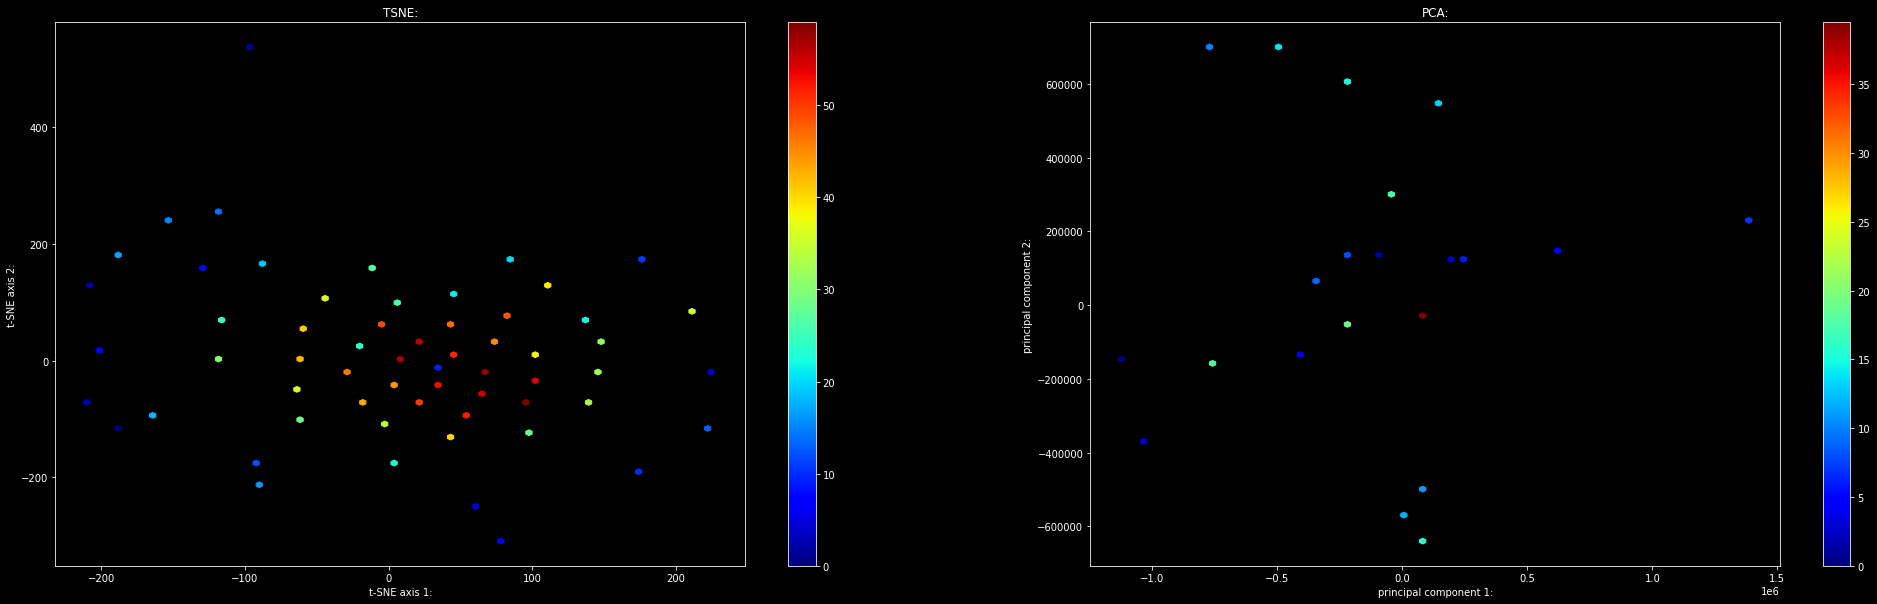

In [280]:
fig, ax  = plt.subplots(1, 2)
fig.set_size_inches(34, 10)

im1 = ax[0].hexbin(all_embeddings_tsne[:, 0], all_embeddings_tsne[:, 1], C=range(len(all_embeddings_tsne)), cmap='jet')
ax[0].set_title('TSNE:')
ax[0].set_xlabel('t-SNE axis 1:')
ax[0].set_ylabel('t-SNE axis 2:')

im2 = ax[1].hexbin(all_embeddings_pca[:, 0], all_embeddings_pca[:, 1], C=range(len(all_embeddings_pca)), cmap='jet')
ax[1].set_title('PCA:')
ax[1].set_xlabel('principal component 1:')
ax[1].set_ylabel('principal component 2:')

plt.colorbar(im1, ax=ax[0])
plt.colorbar(im2, ax=ax[1])
plt.show()

In [311]:
all_weight_vectors = np.concatenate((weight_vector_arrray_three, weight_vector_arrray_one))

In [312]:
tsne = TSNE(n_components=2)
pca = PCA(n_components=2)
all_embeddings_tsne = tsne.fit_transform(all_weight_vectors)
all_embeddings_pca = pca.fit_transform(all_weight_vectors) 

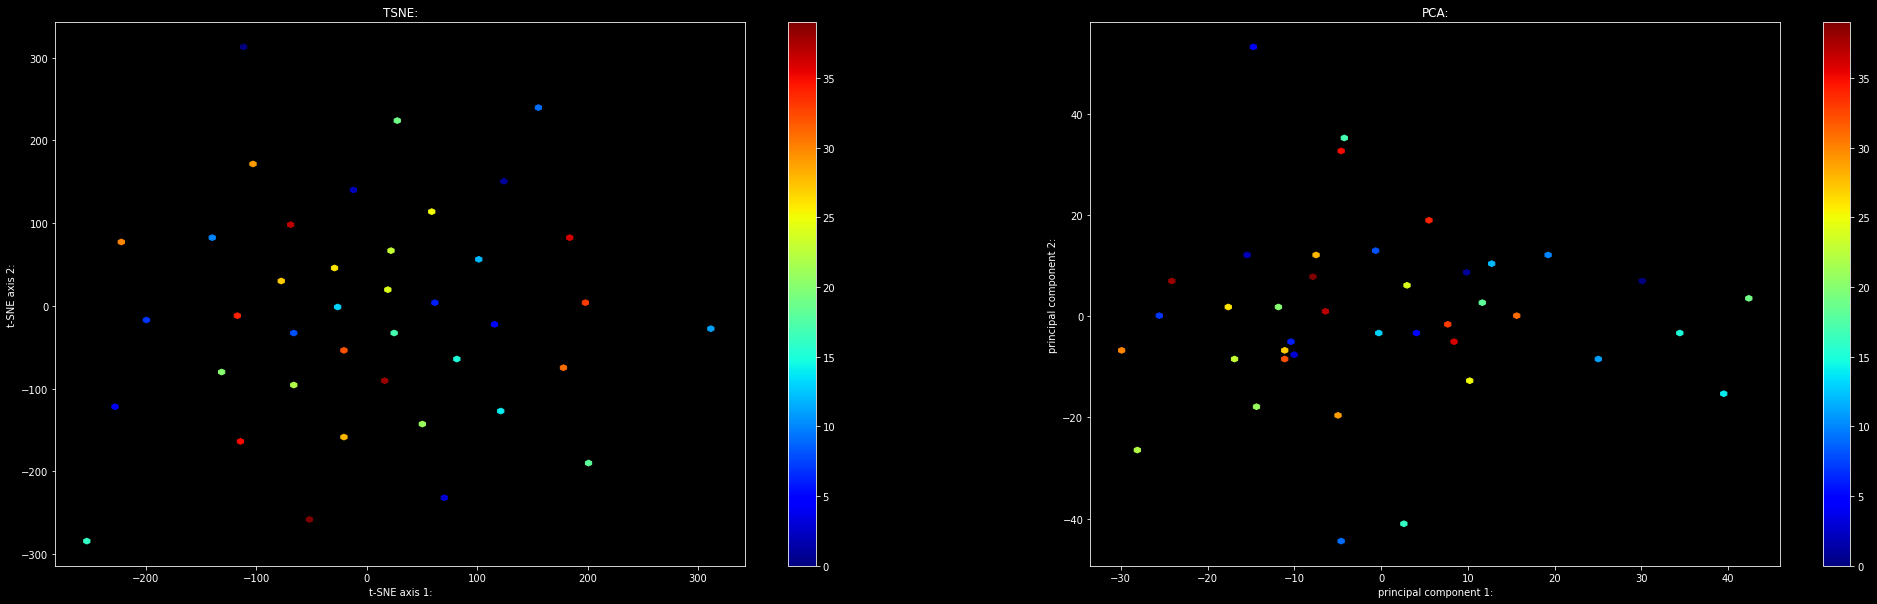

In [313]:
fig, ax  = plt.subplots(1, 2)
fig.set_size_inches(34, 10)

im1 = ax[0].hexbin(all_embeddings_tsne[:, 0], all_embeddings_tsne[:, 1], C=range(len(all_embeddings_tsne)), cmap='jet')
ax[0].set_title('TSNE:')
ax[0].set_xlabel('t-SNE axis 1:')
ax[0].set_ylabel('t-SNE axis 2:')

im2 = ax[1].hexbin(all_embeddings_pca[:, 0], all_embeddings_pca[:, 1], C=range(len(all_embeddings_pca)), cmap='jet')
ax[1].set_title('PCA:')
ax[1].set_xlabel('principal component 1:')
ax[1].set_ylabel('principal component 2:')

plt.colorbar(im1, ax=ax[0])
plt.colorbar(im2, ax=ax[1])
plt.show()